In [1]:
import os
import random
import shutil
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import yaml
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image
import pdb
import sys
sys.path.append('..')
from template import utils#, utils_v2

In [2]:
utils.set_random_seeds()

In [3]:
torch.use_deterministic_algorithms(False)

In [4]:
# setting config
config = yaml.safe_load(open("config.yaml"))
print(f"Our config: {config}")

Our config: {'BATCH_SIZE': 128, 'NUM_EPOCHS': 10, 'LR': '3e-4'}


In [5]:
LFWPeople_tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Pad(2),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

In [6]:
train_dataset = datasets.LFWPeople(root='./data', transform=LFWPeople_tf, split="train",download=True)
test_dataset = datasets.LFWPeople(root='./data', transform=LFWPeople_tf, split="test",download=True)
test_dataset, val_dataset = torch.utils.data.random_split(test_dataset, [0.5, 0.5])

Files already downloaded and verified
Files already downloaded and verified


In [7]:
print(f"train set size: {len(train_dataset)}")
print(f"validation set size: {len(val_dataset)}")
print(f"test set size: {len(test_dataset)}")

train set size: 9525
validation set size: 1854
test set size: 1854


In [8]:
class TripletDataset:
    """
    Dataset class from which we sample random triplets
    """
    def __init__(self, dataset):
        """ Dataset initializer"""
        self.dataset = dataset
        self.arange = np.arange(len(dataset))
        self.labels = torch.Tensor([l for _,l in dataset])
        self._clean_singular_anchors()
        return
    
    def __len__(self):
        """ Returning number of anchors """
        return len(self.dataset)
    
    def _clean_singular_anchors(self):
        """ This method cleans the dataset. It deletes the samples, in which there was only one face (cannot create positive and anchor faces).
        """
        singular_anchors = []
        for i in range(len(self.dataset)):
            _ , anchor_lbl = self.dataset[i]
            pos_ids = self.arange[torch.where(self.labels == anchor_lbl)]
            if isinstance(pos_ids, np.int64):
                singular_anchors.append(i)

        self.dataset = [self.dataset[i] for i in range(len(self.dataset)) if i not in singular_anchors]
        self.labels = torch.Tensor([l for _,l in self.dataset])
        self.arange = np.arange(len(self.dataset))

        print("Number of deleted images", deleted_images)

    def __getitem__(self, i):
        """ 
        Sampling a triplet for the dataset. Index i corresponds to anchor 
        """
        # sampling anchor
        anchor_img, anchor_lbl = self.dataset[i]
        
        
        # lists for positives and negatives
        pos_ids = self.arange[torch.where(self.labels == anchor_lbl)]
        neg_id = self.arange[torch.where(self.labels != anchor_lbl)]
        
        pos_ids = np.delete(pos_ids, 0) # Deleting anchor face from the positive faces. Anchor id is always at the beggining of an array.
        
        pos_id, neg_id = random.choice(pos_ids).item(), random.choice(neg_id).item()
        pos_img, pos_lbl = self.dataset[pos_id] 
        neg_img, neg_lbl = self.dataset[neg_id]
              
        return (anchor_img, pos_img, neg_img), (anchor_lbl, pos_lbl, neg_lbl)

In [9]:
tri_train_dataset = TripletDataset(train_dataset)
tri_val_dataset = TripletDataset(val_dataset)
tri_test_dataset = TripletDataset(test_dataset)

0
1
2
7
10
11
12
19
24
25
33
34
35
36
37
38
39
46
47
53
54
59
60
61
62
65
71
72
73
74
85
86
87
88
89
90
97
98
107
115
116
119
120
121
124
125
126
127
133
134
135
136
137
138
139
142
145
157
158
159
160
200
201
204
205
206
207
208
209
213
214
215
224
225
228
229
235
236
237
238
239
240
241
242
243
244
245
248
249
250
251
252
258
261
264
265
268
269
270
271
274
275
276
277
285
286
287
292
293
307
310
311
312
313
314
315
323
324
325
333
370
371
372
373
374
375
376
377
378
379
380
385
386
387
388
389
395
396
397
398
399
400
401
402
403
404
405
421
422
423
424
425
426
427
441
462
463
464
468
469
470
471
472
473
474
487
488
489
490
495
496
497
498
499
500
503
504
507
508
509
510
511
512
513
514
520
521
526
529
530
531
628
629
638
639
685
701
702
703
716
717
718
719
723
724
725
726
751
752
753
754
755
756
763
764
765
770
771
772
773
774
775
787
788
789
790
793
794
795
800
801
802
803
804
805
806
807
817
818
819
820
826
827
828
829
830
836
837
838
839
851
854
857
858
863
864
865
871
877
878
87

There may be more subtle way to get rid of single "no positive faces except anchor" problem, f.e. making use of them in negative samples but we will try this approach in the beggining.

In [10]:
print(f"train set size after cleanup: {len(tri_train_dataset)}")
print(f"validation set size after cleanup: {len(tri_val_dataset)}")
print(f"test set size after cleanup: {len(tri_test_dataset)}")

train set size after cleanup: 6671
validation set size after cleanup: 1110
test set size after cleanup: 1065


In [11]:
def clip_img(img):
    maxValue = np.amax(img)
    minValue = np.amin(img)
    img = np.clip(img, 0, 1)
    return img

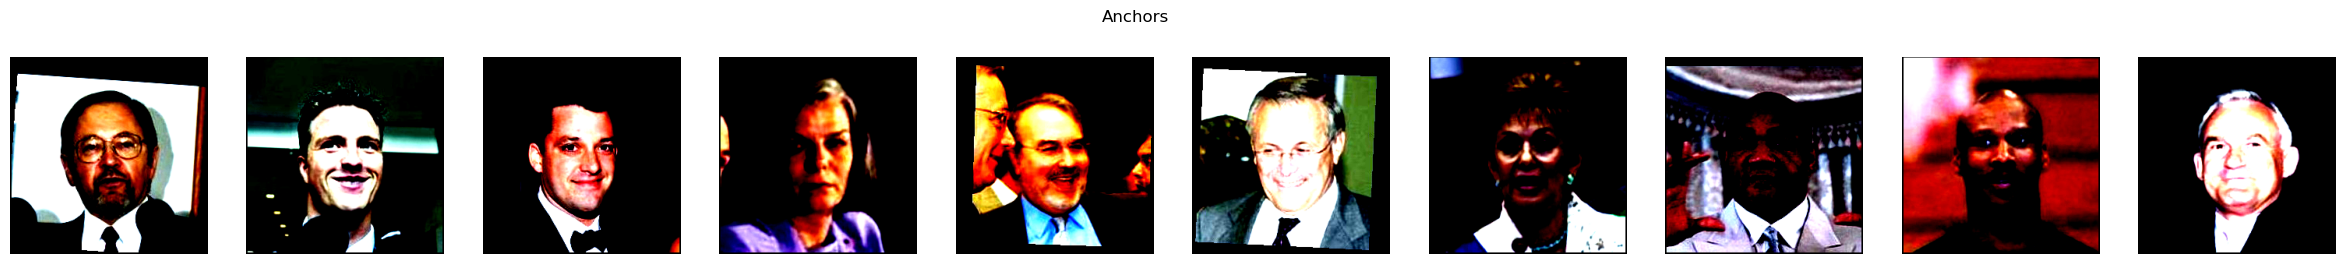

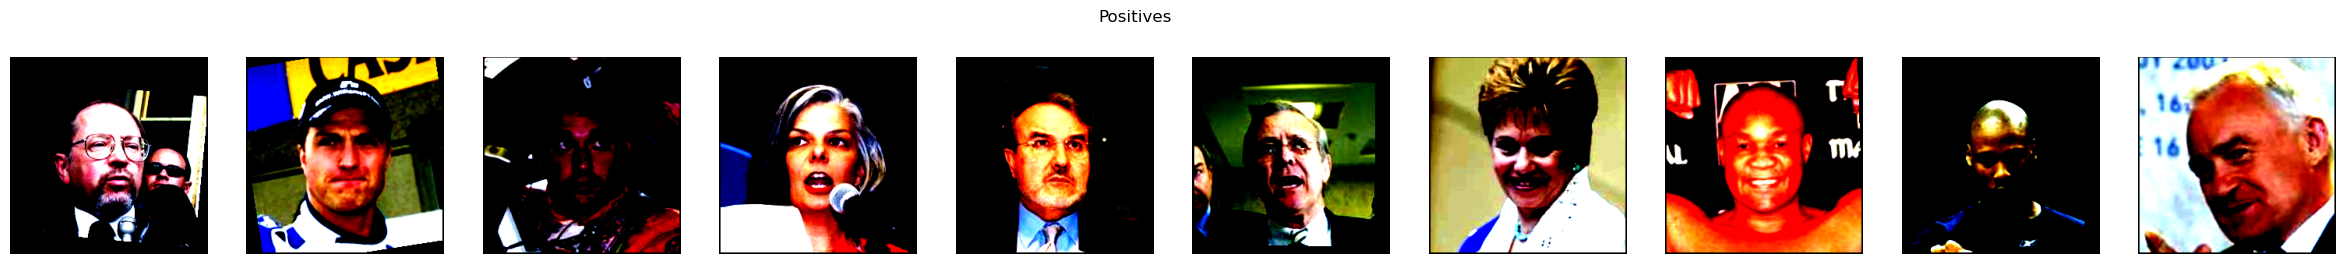

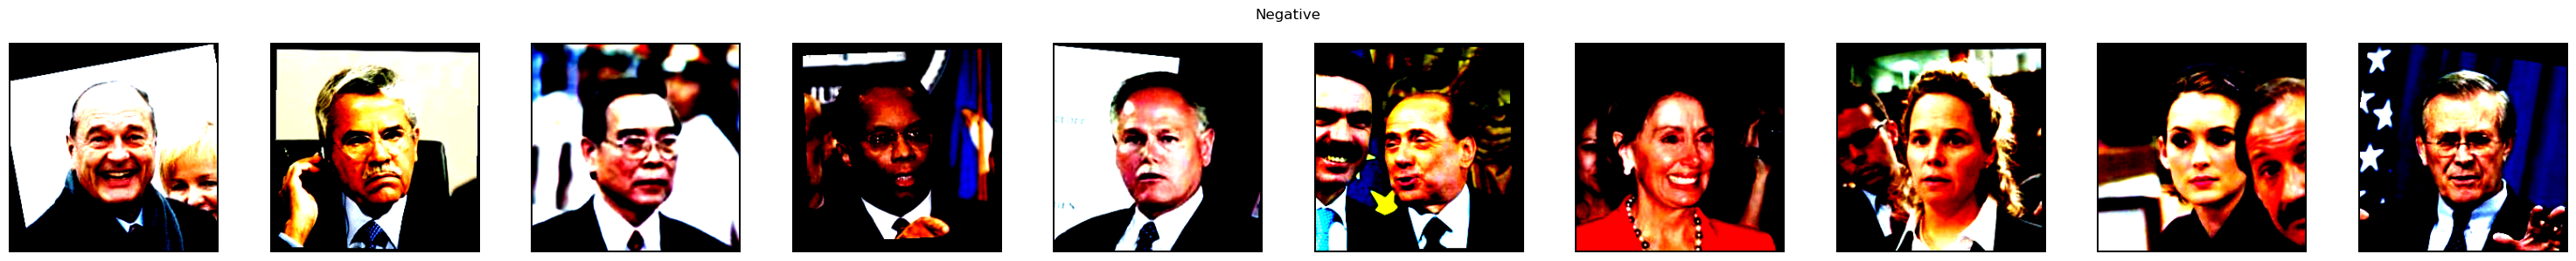

In [12]:
fig_anchors, anchors = plt.subplots(1, 10, figsize=(30,3))
fig_pos, positives = plt.subplots(1, 10, figsize=(30,3))
fig_neg, negatives = plt.subplots(1, 10, figsize=(30,3))
for i in range(10):
    try:
        (anchor, positive, negative), _ = tri_val_dataset[i]
        anchor = anchor.numpy().reshape(3,254,254).transpose(1, 2, 0)
        positive = positive.numpy().reshape(3,254,254).transpose(1, 2, 0)
        negative = negative.numpy().reshape(3,254,254).transpose(1, 2, 0)
        anchor = clip_img(anchor)
        positive = clip_img(positive)
        negative = clip_img(negative)
        anchors[i].imshow(anchor)
        anchors[i].axis("off")
        positives[i].imshow(positive)
        positives[i].axis("off")
        negatives[i].imshow(negative)
        negatives[i].axis("off")
    except ValueError:
        continue
fig_anchors.suptitle("Anchors")
fig_pos.suptitle("Positives")
fig_neg.suptitle("Negative")
plt.tight_layout()

In [13]:
batch_size = int(config["BATCH_SIZE"])

In [14]:
train_loader = torch.utils.data.DataLoader(dataset=tri_train_dataset, batch_size=batch_size, shuffle=True) 
valid_loader = torch.utils.data.DataLoader(dataset=tri_val_dataset, batch_size=batch_size, shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=tri_test_dataset, batch_size=batch_size, shuffle=False) 

## Siamese model

In [15]:
class NormLayer(nn.Module):
    """ Layer that computer embedding normalization """
    def __init__(self, l=2):
        """ Layer initializer """
        assert l in [1, 2]
        super().__init__()
        self.l = l
        return
    
    def forward(self, x):
        """ Normalizing embeddings x. The shape of x is (B,D) """
        x_normalized = x / torch.norm(x, p=self.l, dim=-1, keepdim=True)
        return x_normalized

In [16]:
class SiameseModel(nn.Module):
    """ 
    Implementation of a simple siamese model 
    """
    def __init__(self, emb_dim=32, in_spatial=(32, 32)):
        """ Module initializer """
        super().__init__()
        
        # convolutional feature extractor
        resnet = models.resnet18(pretrained=True)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        
        # fully connected embedder
        self.fc = nn.Linear(512, emb_dim)
        
        # auxiliar layers
        self.flatten = nn.Flatten()
        self.norm = NormLayer()
    
        return
    
    def forward_one(self, x):
        """ Forwarding just one sample through the model """
        x = self.resnet(x)
        x_flat = self.flatten(x)
        x_emb = self.fc(x_flat)
        x_emb_norm = self.norm(x_emb)
        return x_emb_norm
    
    def forward(self, anchor, positive, negative):
        """ Forwarding a triplet """
        anchor_emb = self.forward_one(anchor)
        positive_emb = self.forward_one(positive)
        negative_emb = self.forward_one(negative)
        
        # is there a more efficient way?
        # imgs = torch.concat([anchor, positive, negative], dim=0)
        # embs = self.forward_one(imgs)
        # anchor_emb, positive_emb, negative_emb = torch.chunk(embs, 3, dim=0)
        
        return anchor_emb, positive_emb, negative_emb

In [17]:
model = SiameseModel()

/home/user/lschulze/anaconda3/envs/lab2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/lschulze/anaconda3/envs/lab2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Training
Triplet loss and Trainer shall initially remain unchanged

In [18]:
class TripletLoss(nn.Module):
    """ Implementation of the triplet loss function """
    def __init__(self, margin=0.2, reduce="mean"):
        """ Module initializer """
        assert reduce in ["mean", "sum"]
        super().__init__()
        self.margin = margin
        self.reduce = reduce
        return
        
    def forward(self, anchor, positive, negative):
        """ Computing pairwise distances and loss functions """
        # L2 distances
        d_ap = (anchor - positive).pow(2).sum(dim=-1)
        d_an = (anchor - negative).pow(2).sum(dim=-1)
        
        # triplet loss function
        loss = (d_ap - d_an + self.margin)
        loss = torch.maximum(loss, torch.zeros_like(loss))
        
        # averaging or summing      
        loss = torch.mean(loss) if(self.reduce == "mean") else torch.sum(loss)
      
        return loss

In [19]:
class Trainer:
    """
    Class for training and validating a siamese model
    """
    
    def __init__(self, model, criterion, train_loader, valid_loader, n_iters=1e4, save_freq = 500, margin = 0.2):
        """ Trainer initializer """
        self.model = model
        self.criterion = criterion
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        
        self.n_iters = int(n_iters)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        
        self.margin = 0.2
        self.save_freq = save_freq
        self.train_loss = []
        self.valid_loss = []
        return
    
    @torch.no_grad()
    def valid_step(self, val_iters=100):
        """ Some validation iterations """
        self.model.eval()
        cur_losses = []
        for i, ((anchors, positives, negatives),_) in enumerate(self.valid_loader):   
            # setting inputs to GPU
            anchors = anchors.to(self.device)
            positives = positives.to(self.device)
            negatives = negatives.to(self.device)
            
            # forward pass and triplet loss
            anchor_emb, positive_emb, negative_emb = self.model(anchors, positives, negatives)
            loss = self.criterion(anchor_emb, positive_emb, negative_emb)
            cur_losses.append(loss.item())
            
            if(i >= val_iters):
                break
    
        self.valid_loss += cur_losses
        self.model.train()
        
        return cur_losses
    
    def fit(self):
        """ Train/Validation loop """
        
        self.iter_ = 0
        progress_bar = tqdm(total=self.n_iters, initial=0)
        
        for i in range(self.n_iters):
            for (anchors, positives, negatives), _ in self.train_loader:     
                # setting inputs to GPU
                anchors = anchors.to(self.device)
                positives = positives.to(self.device)
                negatives = negatives.to(self.device)
                
                # forward pass and triplet loss
                anchor_emb, positive_emb, negative_emb = self.model(anchors, positives, negatives)
                loss = self.criterion(anchor_emb, positive_emb, negative_emb)
                self.train_loss.append(loss.item())
                
                # optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            
                # updating progress bar
                progress_bar.set_description(f"Train Iter {self.iter_}: Loss={round(loss.item(),5)})")
                
                # doing some validation every once in a while
                if(self.iter_ % 250 == 0):
                    cur_losses = self.valid_step()
                    print(f"Valid loss @ iteration {self.iter_}: Loss={np.mean(cur_losses)}")
                # saving model every n-th iter
                if(self.iter_ % self.save_freq == 0):
                    stats = {
                    "train_loss": self.train_loss,
                    "valid_loss": self.valid_loss
                    }
                    # utils_v2.save_model(self.model, self.optimizer, self.iter_, stats, margin=self.margin)
                self.iter_ = self.iter_+1 
                if(self.iter_ >= self.n_iters):
                    break
            if(self.iter_ >= self.n_iters):
                break
        return

In [20]:
criterion = TripletLoss(margin=0.2)

In [21]:
trainer = Trainer(model=model, criterion=criterion, train_loader=train_loader, valid_loader=valid_loader, n_iters=1000, save_freq = 100)

In [22]:
torch.cuda.empty_cache()

In [23]:
trainer.fit()

  0%|          | 0/1000 [00:00<?, ?it/s]

Train Iter 0: Loss=0.11219):   0%|          | 0/1000 [00:02<?, ?it/s]

Valid loss @ iteration 0: Loss=0.08832763880491257


Train Iter 250: Loss=0.00512):   0%|          | 0/1000 [01:51<?, ?it/s]

Valid loss @ iteration 250: Loss=0.02095751216014226


Train Iter 500: Loss=0.00456):   0%|          | 0/1000 [03:41<?, ?it/s]

Valid loss @ iteration 500: Loss=0.025824957216779392


Train Iter 750: Loss=0.00888):   0%|          | 0/1000 [05:33<?, ?it/s]

Valid loss @ iteration 750: Loss=0.017017275301946536


Train Iter 999: Loss=0.0):   0%|          | 0/1000 [07:24<?, ?it/s]    


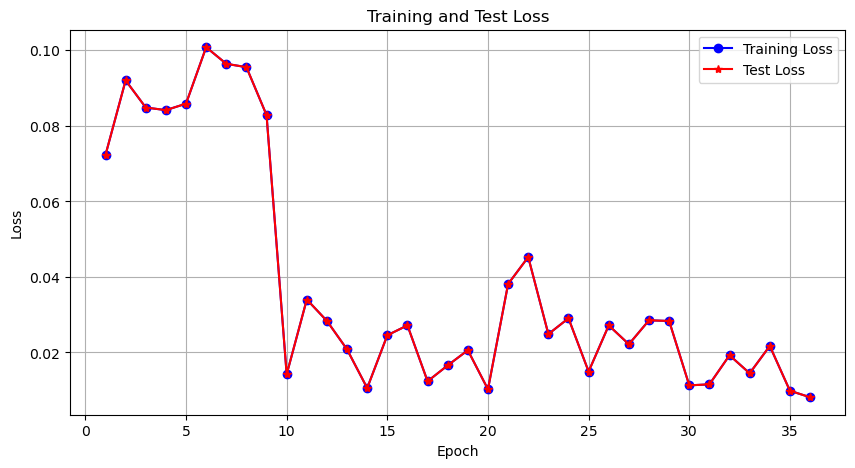

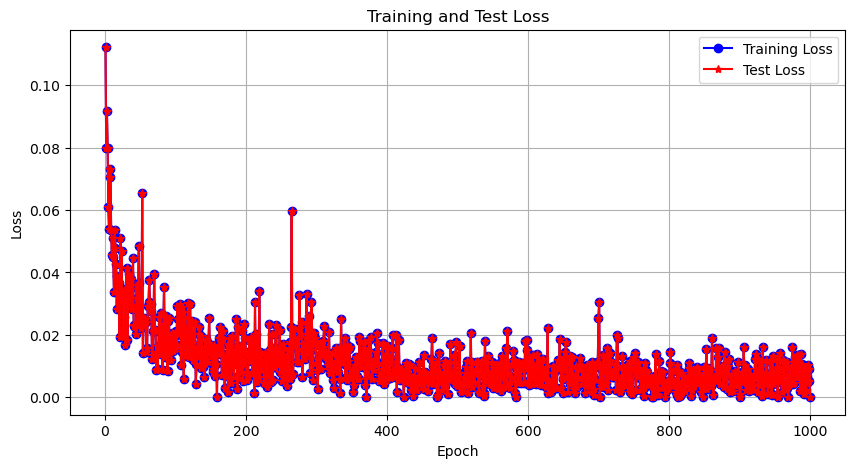

In [24]:
utils.plot_loss_epoch(trainer.valid_loss, trainer.valid_loss)
utils.plot_loss_epoch(trainer.train_loss, trainer.train_loss)

# Visualize Embeddings

In [27]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [ ]:
# model = trainer.model
device = trainer.device
model = model.eval()

In [173]:
labels = torch.Tensor([l for _,l in test_dataset])
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [174]:
# test_dataset = datasets.LFWPeople(root='./data', transform=LFWPeople_tf, split="test",download=True)

# Filtering out labels, which occur more than k times in the test dataset
max_label = int(torch.max(labels).item())

same_labels = []
same_tensors = []
for label in range(max_label):
    indices = torch.where(labels == label)
    if len(indices[0]) > 20:
        selected_tensors = [test_dataset[i][0] for i in indices[0]]
        selected_tensors_labels = [test_dataset[i][1] for i in indices [0]]
        same_tensors.append(torch.stack(selected_tensors))
        same_labels += selected_tensors_labels

embeddings = [model.forward_one(same_tensors[i].to(device)).cpu().detach() for i in range(len(same_tensors))]
imgs_flat = torch.cat(same_tensors).flatten().cpu().detach()

In [177]:
visualization_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

embs = list()
labels = list()
imgs_flat = list()

with torch.no_grad():
    for data, label in visualization_loader:
        data = data.to(device)
        data_embedding = model.forward_one(data)

        labels.append(label)
        embs.append(data_embedding.cpu().flatten(1))
        imgs_flat.append(data.cpu().flatten(1))

labels = np.concatenate(labels)
embs = np.concatenate(embs)
imgs_flat = np.concatenate(imgs_flat)

In [182]:
# Filter out labels, which occur less than k times in our dataset

assert 0 not in same_labels, "0 in same_labels change the label of the undefined cluster"

filtered_labels = [int(labels[i].item()) if labels[i] in same_labels else 0 for i in range(labels.__len__())]

In [168]:
pca_imgs = PCA(n_components=2).fit_transform(imgs_flat)
pca_embs = PCA(n_components=2).fit_transform(embs)

'''
pca_imgs_object = PCA(n_components=2).fit(imgs_flat)
pca_embs_object = PCA(n_components=2).fit(embs)
'''


In [183]:
np.unique(filtered_labels).__len__()

16

In [184]:
def display_projections(points, labels, ax=None, legend=None):
    """ Displaying low-dimensional data projections """
    
    COLORS = ['grey', 'b', 'g', 'y', 'purple', 'orange', 'k', 'brown', 'r',
              'c', "gold", "fuchsia", "lime", "darkred", "tomato", "navy"]
    
    legend = [f"Class {l}" for l in np.unique(labels)] if legend is None else legend
    if(ax is None):
        _, ax = plt.subplots(1,1,figsize=(12,6))
    
    for i,l in enumerate(np.unique(labels)):
        idx = np.where(l==labels)

        ax.scatter(points[idx, 0], points[idx, 1], label=legend[int(i)], c=COLORS[i])
    ax.legend(loc="best")

/tmp/ipykernel_251398/734107461.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


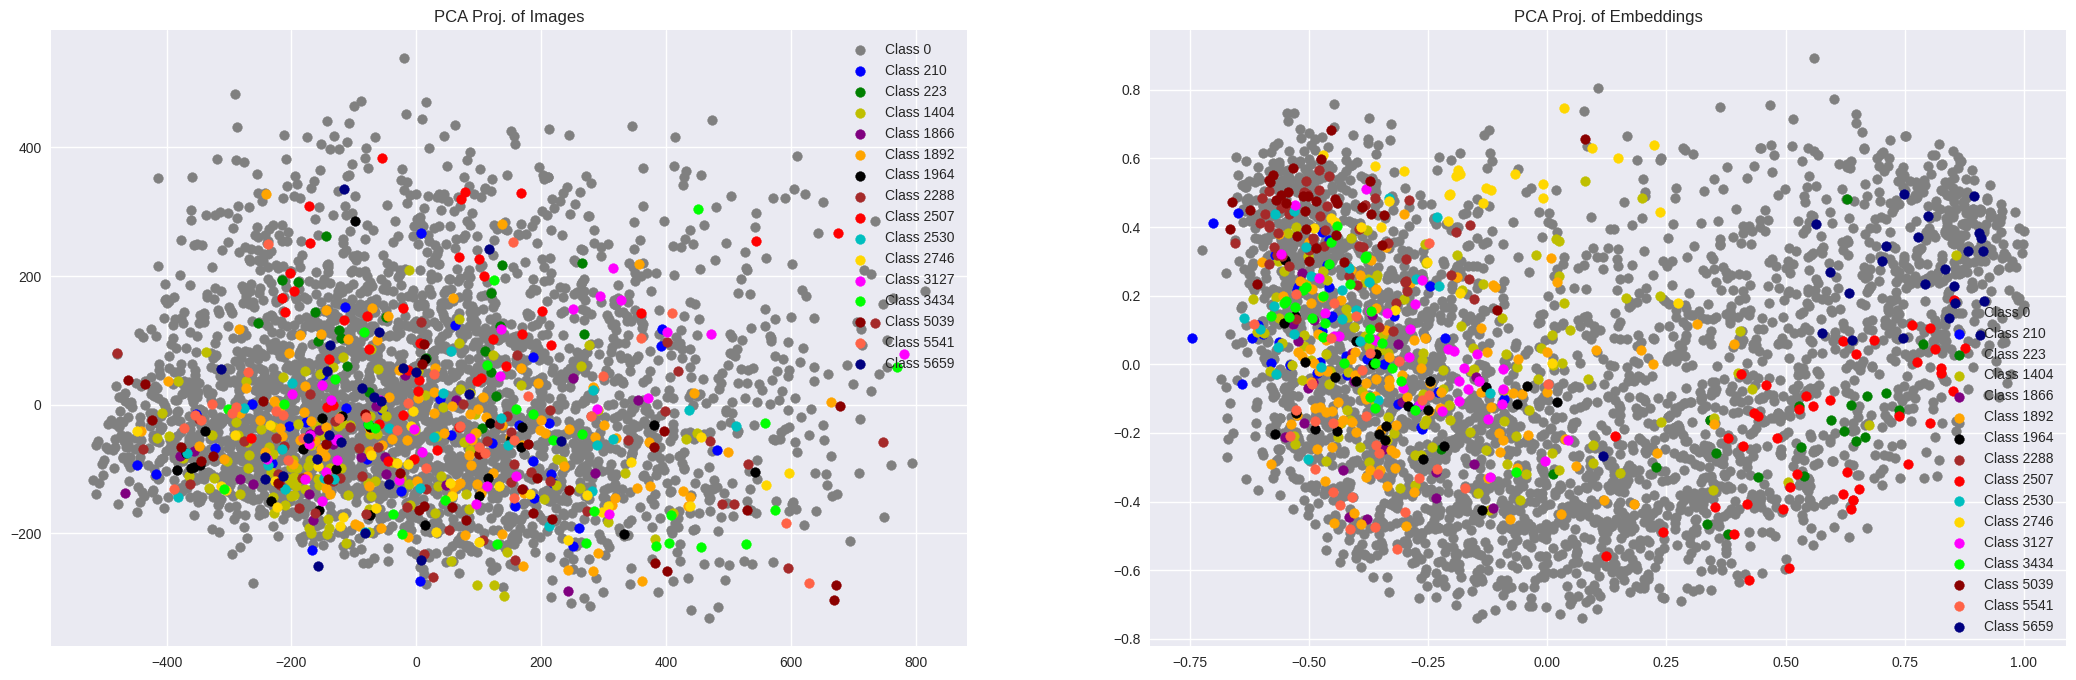

In [185]:
N = 5000
plt.style.use('seaborn')
fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(pca_imgs[:N], filtered_labels[:N], ax=ax[0])
ax[0].set_title("PCA Proj. of Images")
display_projections(pca_embs[:N], filtered_labels[:N], ax=ax[1])
ax[1].set_title("PCA Proj. of Embeddings")
plt.show()

In [186]:
N = 2000
tsne_imgs = TSNE(n_components=2).fit_transform(imgs_flat[:N])
tsne_embs = TSNE(n_components=2).fit_transform(embs[:N])

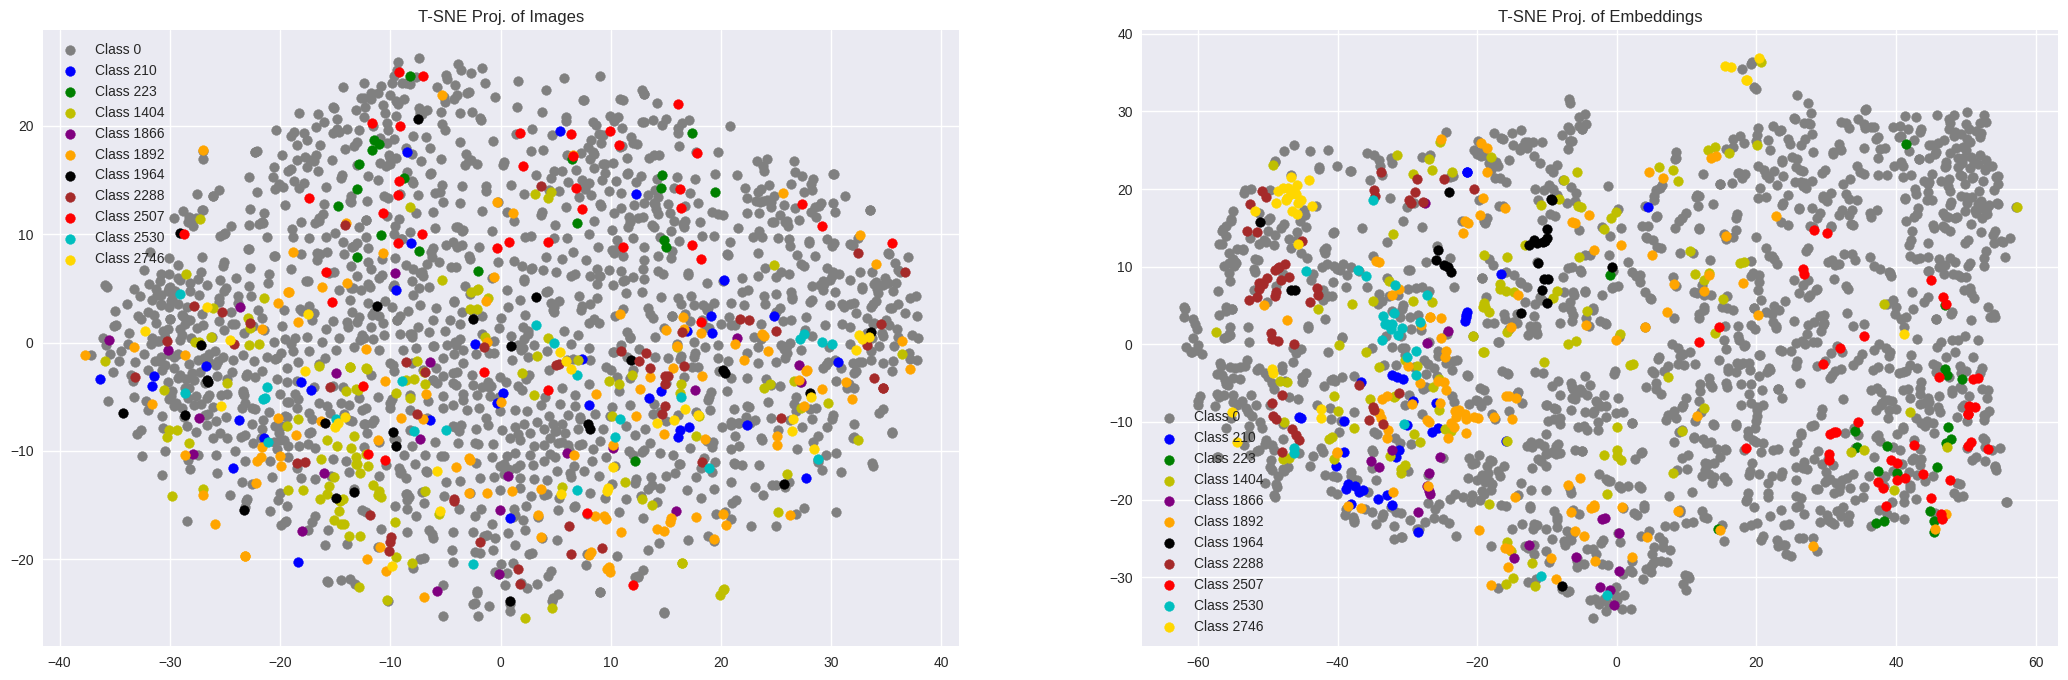

In [187]:
fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(tsne_imgs[:N], filtered_labels[:N], ax=ax[0])
ax[0].set_title("T-SNE Proj. of Images")
display_projections(tsne_embs[:N], filtered_labels[:N], ax=ax[1])
ax[1].set_title("T-SNE Proj. of Embeddings")
plt.show()

In [138]:
'''
def display_projections_no_labels(points, labels, ax=None, legend=None):
    """ Displaying low-dimensional data projections """
    
    COLORS = ['r', 'b', 'g', 'y', 'purple', 'orange', 'k', 'brown', 'grey',
              'c', "gold", "fuchsia", "lime", "darkred", "tomato", "navy"]
    
    legend = [f"Class {l}" for l in np.unique(labels)] if legend is None else legend
    if(ax is None):
        _, ax = plt.subplots(1,1,figsize=(12,6))
    
    for i,l in enumerate(np.unique(labels)):
        idx = np.where(l==labels)
        ax.scatter(points[idx, 0], points[idx, 1])
    ax.legend(loc="best")

    

labels = torch.Tensor([l for _,l in test_dataset])
device = 'cuda' if torch.cuda.is_available() else 'cpu'
max_label = int(torch.max(labels).item())

same_labels = []
same_tensors = []
for label in range(max_label):
    indices = torch.where(labels == label)
    if len(indices[0]) > 10:
        selected_tensors = [test_dataset[i][0] for i in indices[0]]
        selected_tensors_labels = [test_dataset[i][1] for i in indices [0]]
        same_tensors.append(torch.stack(selected_tensors))
        same_labels += selected_tensors_labels

embeddings = [model.forward_one(same_tensors[i].to(device)).cpu().detach() for i in range(len(same_tensors))]
imgs_flat = torch.concatenate(same_tensors, dim = 0).flatten(1).cpu().detach().numpy()

pca_imgs = pca_imgs_object.transform(imgs_flat)
pca_embs = pca_embs_object.transform(embs)

display_projections(pca_imgs, labels = same_labels)
display_projections(pca_embs, labels=same_labels)
'''